In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from skimage import io
import fs
import torchvision
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
import multiprocessing
import torch.nn as nn
cuda = torch.cuda.is_available()
import time
device = torch.device("cuda" if cuda else "cpu")
from tqdm import tqdm 

# invert black and white of MNIST, only do it once

In [ ]:
'''
path='C:/Users/zhaoh/Downloads/FYP/dataset/Mnist/zero/'
i=0
for f in os.listdir(path):
    name=os.path.join(path+str(f))
    if "jpg" in name:
        im = cv2.imread(name)
        i+=1
        im=255-im #invert the color 
        
        cv2.imwrite(name,im)
print(i)#number of images
'''

# segment images from the IPAD

In [51]:
path='C:/Users/zhaoh/Downloads/FYP/dataset/previous train/'#segment the training images from the ipad
keyword=['zero','one','two','three','four','five','six','seven','eight','nine','plus','minus','times','div','equal','decimal']
for f in os.listdir(path):
    name=os.path.join(path+str(f))
    if "png" in name:
        im = cv2.imread(name)
        plt.imshow(im)
        #plt.show()
        for i in range(10):
            for j in range(6):
                ims=im[300+155*i:435+155*i,420+135*j:575+135*j]# corp each cell, and shift to the next cell
                cv2.imwrite(path+keyword[i]+str(np.random.randint(100000,size=1).item())+'.jpg',ims) # save segmented images
                # into the folders according to the keyword so the dataloader could recognize from it


# the dataloader

In [3]:
class DrivingDataset(Dataset):
    def __init__(self,data_dir, input_w=224, input_h=224,is_train=True,transform=None):
        if is_train==False:
            threshold=55#use 50 from each class as validation
        else:
            threshold=450#300 as training
        namelist = [0 for i in range(16)]# 15 list to contain images for each class
        
        self.data_filenames = []
        self.data_ids = []
        self.is_train=is_train

        self.data_root=fs.open_fs(data_dir)
        self.transform = transform
        keyword=['zero','one','two','three','four','five','six','seven','eight','nine','plus','minus','times','div','equal','decimal']
        for p in self.data_root.walk.files(filter=["*.jpg","*.png"]):
            filename=data_dir+p
            if is_train==True or 1==1: #if in training, a label will be given to a training image depending on its folder name
                #like all images of 4 is contained in the folder "four"
                for i,j in enumerate(keyword):
                    if j in filename:
                        if namelist[i]<threshold:
                            self.data_filenames.append(filename)
                            self.data_ids.append(i)
                            namelist[i]+=1
                
            else: #if not training, it is not necessary to load a label
                self.data_filenames.append(filename)
                #self.data_ids.append(0)
        
        
        # print(self.data_filenames)
        #print(namelist)
        print(len(self.data_filenames)) # displays how many images are there in a class


    def __getitem__(self, item):
        """Grey(i, j) = 0.299 × R(i, j) + 0.587 × G(i, j) + 0.114 × B(i, j)"""

        img_path = self.data_filenames[item]
        #print(img_path)
        target = self.data_ids[item]

        image = cv2.imread(img_path) # load the image by getting its path
        
        if self.transform:
            image = self.transform(image) # perform image transform
        
        target = np.array([target], dtype=np.long)
        target = torch.from_numpy(target)
        
        return image,target

    def __len__(self):
        return len(self.data_filenames)
    

# The padding function that ensures all training images to have aspect ratio of 1.0

In [4]:
class ratio_crop(object):
    def __init__(self, ratio=1.0):
        self.ratio = ratio
    def __call__(self, images):
            w=images.shape[1]
            h=images.shape[0]
            aspect_ratio=float(w)/float(h) # the original aspect ratio
            #print(images.shape,aspect_ratio)
            if aspect_ratio==self.ratio:
                a=1
            elif aspect_ratio<self.ratio: 
                dif = np.abs(h  - w) 
                pad1, pad2 = int(dif // 2), int(dif - dif // 2)
                pad = ((0, 0),(pad1, pad2),(0, 0)) # if w<h padding width
                images = np.pad(images, pad, "constant", constant_values=255)
                #input_img = cv2.resize(input_x, (inputwidth, inputheight))
            else:
                dif = np.abs(w  - h) # if w>h padding height
                pad1, pad2 = int(dif // 2), int(dif - dif // 2)
                pad = ((pad1, pad2),(0, 0),(0, 0)) 
                images = np.pad(images, pad, "constant", constant_values=255)
            return images
        
transform = transforms.Compose([
            ratio_crop(1.0),
            transforms.ToPILImage(),
            #transforms.Resize((28,28), interpolation=2),
            #transforms.Pad(5, fill=255, padding_mode='constant'), # padding for 5 white pixels
            #transforms.RandomResizedCrop(56, scale=(0.9, 1.0)), # crop between 0.9 and 1 of the original figure
            transforms.Resize((56,56), interpolation=2), # resize from 155x155 to 56x56
            transforms.ToTensor(),
    ]) 


# remove blank images

In [127]:
path='C:/Users/zhaoh/Downloads/FYP/UI/master/sliced one/'
for f in os.listdir(path):
    name=os.path.join(path+str(f))
    if "jpg" in name:
        im = cv2.imread(name)
        if im.all()!=0:
            os.remove(name)

# the dataloaders

In [5]:
path=''
train_set = DrivingDataset(data_dir="C:/Users/zhaoh/Downloads/FYP/dataset/previous train/", is_train=True,transform=transform) 
val_set = DrivingDataset(data_dir="C:/Users/zhaoh/Downloads/FYP/dataset/eval/", is_train=False,transform=transform) 
test_set = DrivingDataset(data_dir="C:/Users/zhaoh/Downloads/FYP/dataset/test/", is_train=False,transform=transform) 


3747
868
408


In [6]:
batch_size = 50
#n_workers = multiprocessing.cpu_count()

trainloader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_set, batch_size=50,
                                          shuffle=True, num_workers=0)

# visualize some images in the dataset

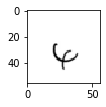

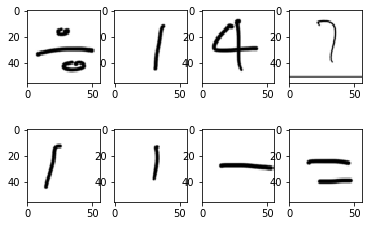

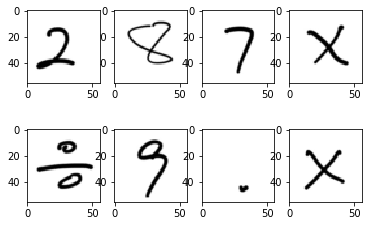

(3, 56, 56)


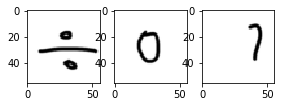

In [7]:
image_batch,label= next(iter(trainloader))
for i in range(20): 
    img = (image_batch[i].numpy())
    plt.subplot(2,4,(i%8+1))
    plt.imshow(img[0],cmap = "gray")
    if i%8==0:
        plt.show()
    
print(img.shape)

# The Resnet

In [8]:

import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url 


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)###########################3 input channels
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    # Allow for accessing forward method in a inherited class
    forward = _forward


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model





def resnet152(pretrained=True, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)

def resnet18(pretrained=True, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    
    return model




# load and modify the network structure

In [ ]:
#torch.save(model.state_dict(), 'model')
#features = model.conv1.in_channels

#model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # change the input image from 3 channel to 1 channel

In [11]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        model.to(device)

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        #Predicted=[]
        for data, target in (test_loader):
            #data = data[:,0] #used for 1 channel input CNN
            data=data.reshape(-1,3,56,56).float().to(device)
            #print(data.shape)
            target=target.squeeze(1)
            target = target.long().to(device)
            
            outputs = model(data)
            
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted.shape)
            #Predicted.append(predicted)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            #loss+=criterion_hinge(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

# the confusion matrix

In [13]:
#model.load_state_dict('1channel')
model=torch.load('new/final3channel.pkl')
confusion=[[0 for i in range(16)]for j in range(16)] # 16*16 matrix
for i,j in valloader:
    #print(i.shape)
    target=j.squeeze(1)
    target = target.long().to(device)
    #print(target)
    #data = i[:,0]
    #print(data.shape)
    data=i.reshape(-1,3,56,56).float().to(device)
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1) # get predicted results
    #print("prediction",len(predicted),len(target))
    for k in range(len(predicted)):
        #print(target[k].item(),' ',predicted[k].item())
        #confusion[17][15]+=1
        #print(confusion[14][15])
        #print(target[k])
        confusion[target[k].item()][predicted[k].item()]+=1 # confusion matrix [label][predicted] add 1
        # count the number of times that one symbol is recognized as any of the 16 classes
            

In [31]:

confusion2=[[0 for i in range(16)]for j in range(16)]
list='    0   1   2   3   4   5   6   7   8   9   +   -   *   /   =   .\n   --------------------------------------------------------------'
print(list)
a=['0 | ','1 | ','2 | ','3 | ','4 | ','5 | ','6 | ','7 | ',
   '8 | ','9 | ','+ | ','- | ','* | ','/ | ','= | ','. | '] # the print form of the matrix

n=confusion
for i in range(len(n)):
    for j in range(len(n[i])):
        if confusion[i][j]!=0:
            confusion2[i][j]=str(confusion[i][j]) # print the number of occrruence
        else:
            confusion2[i][j]='-' # if number of occurrence is 0, use - instaed to make it easier to see
        #print(j)
        if confusion[i][j]<10:
            confusion2[i][j]+=('   ')
        else:
            confusion2[i][j]+=('  ') # add enough blank spaces
        a[i]+=(confusion2[i][j])
        #print(j)
    #a+=sum(i)

for i in a:
    print(i)


    0   1   2   3   4   5   6   7   8   9   +   -   *   /   =   .
   --------------------------------------------------------------
0 | 51  -   -   -   -   -   -   -   -   1   -   -   -   -   -   -   
1 | -   55  -   -   -   -   -   -   -   -   -   -   -   -   -   -   
2 | -   -   54  -   -   -   -   -   -   -   -   -   -   -   -   -   
3 | -   -   1   53  -   -   -   -   -   -   -   -   -   -   -   -   
4 | -   -   -   -   52  -   -   -   -   2   -   -   -   -   -   -   
5 | -   -   -   -   -   54  -   -   -   -   -   -   -   -   -   -   
6 | -   1   -   -   -   -   52  -   -   -   -   -   -   -   -   -   
7 | -   -   -   -   -   -   -   54  -   -   -   -   -   -   -   -   
8 | -   -   -   -   -   2   1   -   51  -   -   -   -   -   -   -   
9 | -   -   -   -   -   -   -   1   -   53  -   -   -   -   -   -   
+ | -   -   -   -   -   -   -   -   -   -   55  -   -   -   -   -   
- | -   -   -   -   -   -   -   -   -   -   -   55  -   -   -   -   
* | 2   -   -   -   -   -   -   -   -   

# highest confidence error

In [43]:
# measures the errors that have the highest confidence score
model=torch.load('3channel88.pkl')
model.eval()
test_set = DrivingDataset(data_dir="C:/Users/zhaoh/Downloads/FYP/dataset/eval/", is_train=False,transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=10,
                                          shuffle=False, num_workers=0)

scores=[[]for i in range(16)]
indexes=[[]for i in range(16)]
result=[[]for i in range(16)]
label=[[]for i in range(16)]

for index,(k,j) in enumerate(testloader):
    #i=255-i
    #print(i.shape)
    #data = k[:,0]
    data=k.reshape(-1,3,56,56).float().to(device)
    target=j.squeeze(1)
    target = target.to(device)
    outputs = model(data)
    score, predicted = torch.max(outputs.data, 1)
    #print("prediction",index)#batch result confidence 
    for i in range(len(score)):
        if predicted[i]!=target[i].long():
            #ni=ni+1
            reg=target[i].item()
            #print(target[i].item())
            #print(a[reg])
            #if score[i].item()>a[reg][0]:
            scores[reg].append(score[i].item()) #records the score
            indexes[reg].append(index*10+i) #records the index of that image
            result[reg].append(predicted[i]) #record the prediction result
            label[reg].append(target[i]) #record the prediction target



868


In [47]:
import heapq
originalindex=[]
originalresult=[]
originallabel=[]
for k in range(len(a)):
    for i in range (5):
        try:
            index=scores[k].index(heapq.nlargest(5,scores[k])[i]) # try to find 5 highest confidence errors from one class
            originalindex.append(indexes[k][index]) # find the original index of the image by reading the index matrix
            originalresult.append(result[k][index]) # original result
            originallabel.append(label[k][index]) # original label
        except:
            print('no') # there are less than 5 errors in this class

no
no
no
no
no
no
no
no
no


predicted  tensor(4, device='cuda:0')   actual  tensor(0, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(0, device='cuda:0', dtype=torch.int32)
predicted  tensor(9, device='cuda:0')   actual  tensor(0, device='cuda:0', dtype=torch.int32)
predicted  tensor(3, device='cuda:0')   actual  tensor(0, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(0, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(1, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(1, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(1, device='cuda:0', dtype=torch.int32)


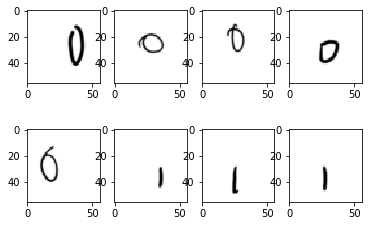

predicted  tensor(15, device='cuda:0')   actual  tensor(1, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(1, device='cuda:0', dtype=torch.int32)
predicted  tensor(3, device='cuda:0')   actual  tensor(2, device='cuda:0', dtype=torch.int32)
predicted  tensor(3, device='cuda:0')   actual  tensor(2, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(2, device='cuda:0', dtype=torch.int32)
predicted  tensor(3, device='cuda:0')   actual  tensor(2, device='cuda:0', dtype=torch.int32)
predicted  tensor(13, device='cuda:0')   actual  tensor(2, device='cuda:0', dtype=torch.int32)
predicted  tensor(8, device='cuda:0')   actual  tensor(3, device='cuda:0', dtype=torch.int32)


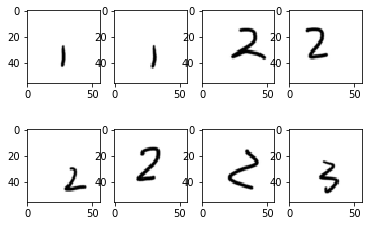

predicted  tensor(7, device='cuda:0')   actual  tensor(3, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(3, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(3, device='cuda:0', dtype=torch.int32)
predicted  tensor(6, device='cuda:0')   actual  tensor(3, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(4, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(4, device='cuda:0', dtype=torch.int32)
predicted  tensor(6, device='cuda:0')   actual  tensor(4, device='cuda:0', dtype=torch.int32)
predicted  tensor(10, device='cuda:0')   actual  tensor(4, device='cuda:0', dtype=torch.int32)


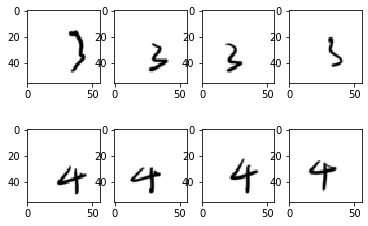

predicted  tensor(7, device='cuda:0')   actual  tensor(5, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(5, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(5, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(5, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(5, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(6, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(6, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(6, device='cuda:0', dtype=torch.int32)


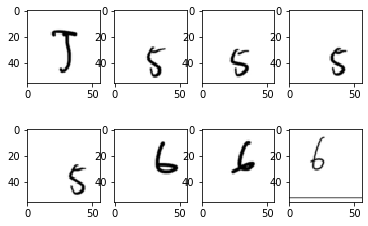

predicted  tensor(4, device='cuda:0')   actual  tensor(6, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(6, device='cuda:0', dtype=torch.int32)
predicted  tensor(1, device='cuda:0')   actual  tensor(7, device='cuda:0', dtype=torch.int32)
predicted  tensor(2, device='cuda:0')   actual  tensor(7, device='cuda:0', dtype=torch.int32)
predicted  tensor(2, device='cuda:0')   actual  tensor(7, device='cuda:0', dtype=torch.int32)
predicted  tensor(1, device='cuda:0')   actual  tensor(7, device='cuda:0', dtype=torch.int32)
predicted  tensor(1, device='cuda:0')   actual  tensor(7, device='cuda:0', dtype=torch.int32)
predicted  tensor(6, device='cuda:0')   actual  tensor(8, device='cuda:0', dtype=torch.int32)


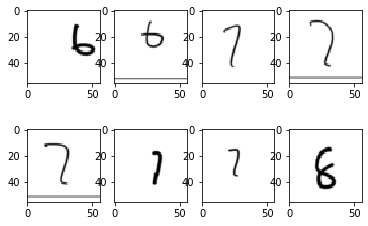

predicted  tensor(9, device='cuda:0')   actual  tensor(8, device='cuda:0', dtype=torch.int32)
predicted  tensor(6, device='cuda:0')   actual  tensor(8, device='cuda:0', dtype=torch.int32)
predicted  tensor(9, device='cuda:0')   actual  tensor(8, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(8, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(9, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(9, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(9, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(9, device='cuda:0', dtype=torch.int32)


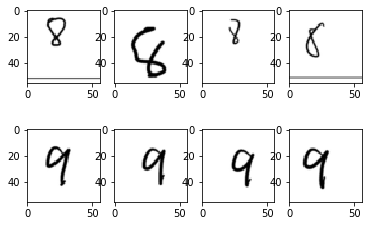

predicted  tensor(4, device='cuda:0')   actual  tensor(9, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(10, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(10, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(10, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(10, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(10, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(11, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(11, device='cuda:0', dtype=torch.int32)


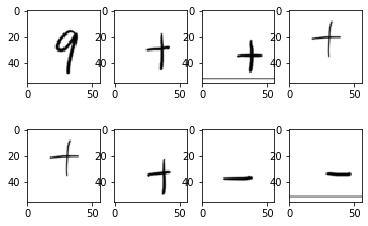

predicted  tensor(4, device='cuda:0')   actual  tensor(12, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(12, device='cuda:0', dtype=torch.int32)
predicted  tensor(9, device='cuda:0')   actual  tensor(12, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(12, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(12, device='cuda:0', dtype=torch.int32)
predicted  tensor(11, device='cuda:0')   actual  tensor(13, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(13, device='cuda:0', dtype=torch.int32)
predicted  tensor(11, device='cuda:0')   actual  tensor(13, device='cuda:0', dtype=torch.int32)


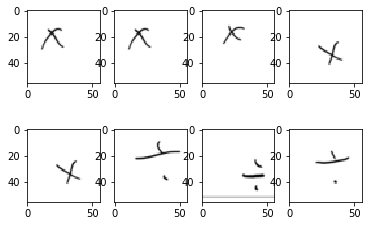

predicted  tensor(11, device='cuda:0')   actual  tensor(13, device='cuda:0', dtype=torch.int32)
predicted  tensor(11, device='cuda:0')   actual  tensor(13, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(14, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(14, device='cuda:0', dtype=torch.int32)
predicted  tensor(15, device='cuda:0')   actual  tensor(14, device='cuda:0', dtype=torch.int32)
predicted  tensor(7, device='cuda:0')   actual  tensor(14, device='cuda:0', dtype=torch.int32)
predicted  tensor(4, device='cuda:0')   actual  tensor(14, device='cuda:0', dtype=torch.int32)


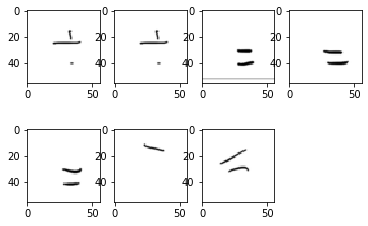

In [48]:
n=1
for i in range(len(c)):
        n+=1
        img = np.moveaxis(test_set[originalindex[i]][0].numpy(),0,2)
        plt.subplot(2,4,i%8+1)
        plt.imshow(img)
        print('predicted ',originalresult[i],'  actual ',originallabel[i])
        if i%8==7:
            plt.show()
        
#print(n)

# visualize the activation maps of the CNN

In [20]:
#define the network in the design specification
class Simple(nn.Module):
    def __init__(self):
        super(Simple, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 56, 56)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 56, 56)
            nn.ReLU(),
            torch.nn.BatchNorm2d(16),# activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 28, 28)
        )#32
        self.conv2 = nn.Sequential(         # input shape (16, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 28, 28)
            nn.ReLU(),
            torch.nn.BatchNorm2d(32),# activation
            nn.MaxPool2d(2),                # output shape (32, 14, 14)
        )
        self.conv3 = nn.Sequential(         # input shape (32, 14, 14)
            nn.Conv2d(32, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),
            torch.nn.BatchNorm2d(32),# activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out1 = nn.Sequential(nn.Linear(32 * 7 * 7, 512), # input size 32*7*7 output size 512 fully connected layer
            nn.Dropout(0.3) #dropout probability 0.3
        )
        self.out2 = nn.Linear(512, 16)
        # fully connected layer, output 16 classes
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1) ## flatten the output of conv2 to (batch_size, 32 * 7 * 7)  
        x=self.out1(x)
        #print(x.shape)
        output = self.out2(x)
        return output   

11


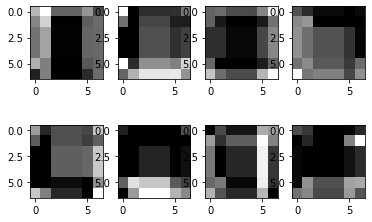

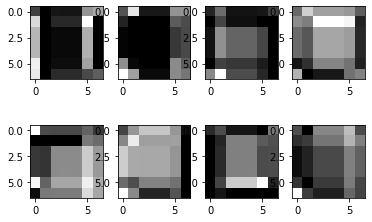

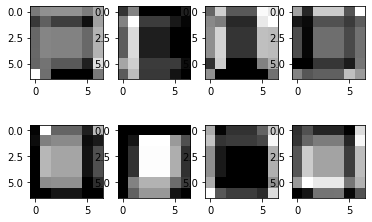

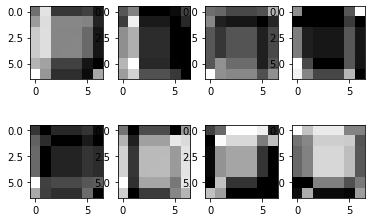

In [32]:
model=torch.load('new/simplefinal.pkl')
#model.conv2 = nn.Dropout(0)
#model.conv3 = nn.Dropout(0)
model.out1 = nn.Dropout(0)
model.out2 = nn.Dropout(0) # setting layers behinds to nothing so that the output of the network will be the activation maps
#print(model)
model.eval()
test_set = DrivingDataset(data_dir="C:/Users/zhaoh/Downloads/FYP/UI/master/sliced one/", is_train=False,transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                          shuffle=False, num_workers=0)
channel=32
size=7 # need to set these according to the dimension of the activation map
for i,j in testloader:
    #i=255-i
    #print(i.shape)
    data = i[:,0] # using 1 channel input images
    data=data.reshape(-1,1,56,56).float().to(device)
    outputs = model(data)
    #print('o ',outputs.shape)
    outputs=np.reshape(outputs.cpu().detach(),(channel,size,size))
    # outputs is the activation map
    for k in range(channel):
        plt.subplot(2,4,k%8+1)
        #img = np.moveaxis(i[:,k].numpy(),0,2)
        #print(outputs[k].shape)
        img=np.reshape(outputs[k].cpu().detach(),(size,size))
        #img = np.moveaxis(i[:,k].numpy(),0,2)
        plt.imshow(img,cmap='gray')
        if k%8==7:
            plt.show()
    break
